# 蜜宝大数据风控解决方案

---

## 会议主题：
1. 审核大数据风控可行性。
2. 工作计划。


## 数据挖掘工作流程

目前大数据风控做的第一件事是数据挖掘工作，数据挖掘的工作流程分下面七步完成：

1. 目标或问题定义。
2. 获取数据。
3. 数据分析。
4. 数据清洗、特征处理。
5. 机器学习训练、预测。
6. 结果评估和报告。
7. 总结。


## 目标或问题定义

当我们面对客户提交的租赁设备订单请求时，我们有2个核心问题需要解决，一个是这个客户信用如何，是不是来欺诈的；另一个是这个客户是信用良好客户，但我们不确定这个设备的价格是否超出他所能承受的范围。因此，我们的任务目标是两个：
1. 客户分类。把客户分成审核通过和审核拒绝两类。
2. 确定客户信用额度。

下面介绍的数据挖掘工作是实现客户分类的。

## 开始数据挖掘工作
先做些代码初始化

In [1]:

import csv
import json
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import time
import os
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier


def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
                                                              "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns


# 特征分析
def feature_analyse(df, col, bins=10):
    if df[col].dtype != 'O':
        col_band = col + '_band'
        df[col_band] = pd.cut(df[col], bins).astype(str)
        col_ana = col_band
    else:
        col_ana = col

    print(df[col_ana].describe())
    print("-------------------------------------------")
    pass_df = pd.DataFrame({'pass': df[df['check_result'] == 1][col_ana].value_counts()})
    reject_df = pd.DataFrame({'reject': df[df['check_result'] == 0][col_ana].value_counts()})
    all_df = pd.DataFrame({'all': df[col_ana].value_counts()})
    analyse_df = all_df.merge(pass_df, how='outer', left_index=True, right_index=True)
    analyse_df = analyse_df.merge(reject_df, how='outer', left_index=True, right_index=True)
    analyse_df['pass_rate'] = analyse_df['pass'] / analyse_df['all']
    analyse_df.sort_values(by='pass_rate', inplace=True, ascending=False)
    analyse_df.fillna(value=0, inplace=True)
    print(analyse_df)
    plt.bar(analyse_df.index, analyse_df['pass_rate'])
    plt.ylabel('Pass Rate')


# KDE plot
def feature_kdeplot(df, feature):
    sns.kdeplot(df.loc[df['check_result'] == 0, feature], label='reject')
    sns.kdeplot(df.loc[df['check_result'] == 1, feature], label='pass')

    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.title('Distribution of ' + feature)


def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better.

    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance

    Returns:
        shows a plot of the 15 most importance features

        df (dataframe): feature importances sorted by importance (highest to lowest)
        with a column for normalized importance
        """

    # Sort features according to importance
    df = df.sort_values('importance', ascending=False).reset_index()

    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize=(10, 6))
    ax = plt.subplot()

    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))),
            df['importance_normalized'].head(15),
            align='center', edgecolor='k')

    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))

    # Plot labeling
    plt.xlabel('Normalized Importance');
    plt.title('Feature Importances')
    plt.show()

    return df

    
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')    
# to make output display better
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.width', 2000)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['font.sans-serif'] = ['Simhei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
# read large csv file
csv.field_size_limit(100000000)

131072

## 获取数据

数据已经从数据库中导出成csv文件，直接读取即可。后面数据的读取更改为从备份数据库直接读取，不仅可以保证数据的完整，还可以避免重名字段处理的麻烦。

In [2]:
# Datasets info
PROJECT_ROOT_DIR = os.getcwd()
DATA_ID = "学校数据.csv"
DATASETS_PATH = os.path.join(PROJECT_ROOT_DIR, "datasets", DATA_ID)
df_alldata = pd.read_csv(DATASETS_PATH, encoding='utf-8', engine='python')
print("初始数据量: {}".format(df_alldata.shape))

初始数据量: (86988, 209)


## 数据简单计量分析


In [3]:
# 首5行数据
df_alldata.head()

,id,create_time,deleted,update_time,check_time,...,order_number.4,max_lease,min_lease,renew_rents,rent_group
0,131,2/11/2017 17:44:55,0,2/11/2017 18:34:33,NaN,...,NaN,NaN,NaN,NaN,NaN
1,132,2/11/2017 18:08:32,0,2/11/2017 18:34:00,NaN,...,NaN,NaN,NaN,NaN,NaN
2,133,2/11/2017 18:15:12,0,28/11/2017 09:43:09,NaN,...,NaN,NaN,NaN,NaN,NaN
3,134,2/11/2017 22:10:20,0,28/11/2017 09:40:44,NaN,...,NaN,NaN,NaN,NaN,NaN
4,135,2/11/2017 22:53:54,0,15/11/2017 10:38:45,NaN,...,NaN,NaN,NaN,NaN,NaN


In [4]:
# 最后5行数据
df_alldata.tail()

,id,create_time,deleted,update_time,check_time,...,order_number.4,max_lease,min_lease,renew_rents,rent_group
86983,77217,21/8/2018 15:55:05,0,21/8/2018 15:55:33,NaN,...,2.018082e+18,0.0,0.0,"{""360"":1360,""180"":1390}",NaN
86984,77219,21/8/2018 15:57:53,0,21/8/2018 15:58:25,NaN,...,2.018082e+18,0.0,0.0,"{""360"":1360,""180"":1390}",NaN
86985,77220,21/8/2018 15:58:19,0,21/8/2018 15:58:20,NaN,...,2.018082e+18,0.0,0.0,"{""360"":1520}",NaN
86986,77220,21/8/2018 15:58:19,0,21/8/2018 15:58:20,NaN,...,2.018082e+18,0.0,0.0,"{""360"":1520}",NaN
86987,77221,21/8/2018 16:00:31,0,21/8/2018 16:01:00,NaN,...,2.018082e+18,0.0,0.0,"{""180"":1190,""60"":1590,""30"":2090,""360"":990,""90""...",NaN


In [5]:
# 所有特征值
df_alldata.columns.values

array(['id', 'create_time', 'deleted', 'update_time', 'check_time',
       'check_author', 'credit_check_time', 'lease_start_time',
       'lease_expire_time', 'finished_time', 'canceled_time',
       'received_time', 'delivery_time', 'last_pay_time', 'buyout_time',
       'order_number', 'merchant_id', 'merchant_name', 'name', 'user_id',
       'user_name', 'goods_name', 'goods_sn', 'state', 'cost', 'discount',
       'pay', 'installment', 'next_pay_time', 'rem_pay_num',
       'ismt_agmt_url', 'ismt_agmt_no', 'pay_num', 'added_service',
       'first_pay', 'first_pay_time', 'full', 'billing_method',
       'liquidated_damages_percent', 'buffer_days', 'channel', 'pay_type',
       'user_receive_time', 'reminded', 'bounds_example_id',
       'bounds_example_name', 'bounds_example_no', 'goods_type',
       'need_zmxy_feedback', 'cash_pledge', 'version', 'cancel_reason',
       'clearance_time', 'freight', 'paid_amount', 'credit_check_author',
       'reminder_time', 'lease_term', 'comme

In [37]:
# 我们并不需要所有的特征值，筛选出一些可能有用的特质值
df = df_alldata.dropna(axis=1, how='all')

features = ['create_time', 'goods_name', 'cost', 'discount', 'pay_num', 'added_service', 'first_pay', 'channel',
            'pay_type', 'merchant_id', 'goods_type', 'lease_term', 'daily_rent', 'accident_insurance', 'type',
            'freeze_money', 'ip', 'releted', 'order_type', 'source', 'disposable_payment_discount',
            'disposable_payment_enabled', 'lease_num', 'original_daily_rent', 'deposit', 'zmxy_score', 'card_id',
            'contact', 'phone', 'provice', 'city', 'regoin', 'receive_address', 'emergency_contact_name', 'phone_book',
            'emergency_contact_phone', 'emergency_contact_relation', 'type.1', 'detail_json', 'price', 'old_level']
result = ['state', 'cancel_reason', 'check_result', 'check_remark', 'result']
df = df[result + features]
print("筛选出所有可能有用特征后的数据量: {}".format(df.shape))


筛选出所有可能有用特征后的数据量: (86988, 46)


In [38]:
# 数据的起止时间段
print("数据起止时间段：{} -- {}".format(df['create_time'].iloc[0], df['create_time'].iloc[-1]))

数据起止时间段：2/11/2017 17:44:55 -- 21/8/2018 16:00:31


In [39]:
# 订单审核结果分类
df['check_result'].value_counts()

FAILURE    66970
INIT       11075
SUCCESS     6464
Name: check_result, dtype: int64

In [40]:
# 订单状态
df['state'].value_counts()

artificial_credit_check_unpass_canceled    50144
user_canceled                              19433
order_payment_overtime_canceled             4926
system_credit_check_unpass_canceled         4597
lease_finished                              3289
running                                     2964
buyout_finished                              318
running_overdue                              212
merchant_not_yet_send_canceled               210
pending_jimi_credit_check                    192
                                           ...  
pending_return                                 8
pending_relet_start                            6
pending_artificial_credit_check                5
express_rejection_canceled                     4
pending_relet_pay                              2
repairing                                      2
returned_received                              2
merchant_relet_check_unpass_canceled           1
pending_compensate_check                       1
exchange_goods      

In [41]:
# 查看非空值个数， 数据类型
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86988 entries, 0 to 86987
Data columns (total 46 columns):
state                          86988 non-null object
cancel_reason                  81101 non-null object
check_result                   84509 non-null object
check_remark                   69375 non-null object
result                         42081 non-null object
create_time                    86988 non-null object
goods_name                     86988 non-null object
cost                           86988 non-null int64
discount                       5090 non-null float64
pay_num                        86988 non-null int64
added_service                  60601 non-null object
first_pay                      8613 non-null float64
channel                        74939 non-null object
pay_type                       8613 non-null object
merchant_id                    86988 non-null int64
goods_type                     86988 non-null object
lease_term                     86988 non-null i

In [42]:
df.dtypes.value_counts()

object     29
int64      14
float64     3
dtype: int64

In [43]:
# 缺失值比率
missing_values_table(df)

Your selected dataframe has 46 columns.
There are 24 columns that have missing values.


,Missing Values,% of Total Values
discount,81898,94.1
first_pay,78375,90.1
pay_type,78375,90.1
emergency_contact_name,75998,87.4
emergency_contact_relation,75966,87.3
emergency_contact_phone,75966,87.3
phone_book,75966,87.3
detail_json,44907,51.6
result,44907,51.6
type.1,44907,51.6


In [44]:
# 特征中不同值得个数
df.select_dtypes('object').apply(pd.Series.nunique, axis=0)

state                            29
cancel_reason                  1817
check_result                      3
check_remark                   1461
result                            6
create_time                   71679
goods_name                     1146
added_service                    27
channel                          20
pay_type                          5
                              ...  
provice                          61
city                            572
regoin                         2458
receive_address               45283
emergency_contact_name         3156
phone_book                     4437
emergency_contact_relation        8
type.1                            2
detail_json                   42081
old_level                         7
Length: 29, dtype: int64

In [45]:
#  数值描述
df.describe()

,cost,discount,pay_num,first_pay,merchant_id,lease_term,daily_rent,accident_insurance,freeze_money,releted,disposable_payment_discount,disposable_payment_enabled,lease_num,original_daily_rent,deposit,emergency_contact_phone,price
count,8.698800e+04,5090.000000,86988.000000,8613.000000,86988.000000,86988.000000,86988.000000,86988.000000,86988.000000,86988.000000,86988.000000,86988.000000,86988.000000,86988.000000,8.698800e+04,1.102200e+04,8.698800e+04
mean,3.485882e+05,6589.563654,9.894813,28841.315569,102.485538,295.130926,1681.398952,19646.031889,8148.927772,0.001069,4.301593,0.047455,1.005265,472.213800,1.796072e+05,1.584046e+10,1.021291e+06
std,2.826644e+05,9810.737018,4.157293,50198.934737,120.425726,128.557417,8911.079098,19589.970694,51449.458713,0.032680,19.382748,0.212611,0.262799,919.463761,1.720771e+07,2.064116e+09,2.467316e+07
min,1.000000e+00,-525300.000000,1.000000,0.000000,22.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,1.300108e+10,0.000000e+00
25%,1.800000e+05,2000.000000,12.000000,7000.000000,22.000000,360.000000,730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,1.377756e+10,3.500000e+05
50%,3.589200e+05,3000.000000,12.000000,19200.000000,46.000000,360.000000,1163.000000,19800.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,1.554557e+10,6.688000e+05
75%,4.788000e+05,10000.000000,12.000000,35600.000000,161.000000,360.000000,1463.000000,29800.000000,0.000000,0.000000,0.000000,0.000000,1.000000,890.000000,0.000000e+00,1.808622e+10,8.388000e+05
max,7.560000e+06,78800.000000,13.000000,859000.000000,483.000000,365.000000,1000000.000000,506150.000000,982500.000000,1.000000,100.000000,1.000000,20.000000,30000.000000,3.588359e+09,1.998726e+10,3.588359e+09


In [46]:
# 类别描述
df.describe(include='O')

,state,cancel_reason,check_result,check_remark,result,create_time,goods_name,added_service,channel,pay_type,goods_type,type,ip,order_type,source,zmxy_score,card_id,contact,phone,provice,city,regoin,receive_address,emergency_contact_name,phone_book,emergency_contact_relation,type.1,detail_json,old_level
count,86988,81101,84509,69375,42081,86988,86988,60601,74939,8613,86988,86988,82326,86988,86988,82587,86202,86202,86202,83823,83823,81952,86202,10990,11022,11022,42081,42081,86988
unique,29,1817,3,1461,6,71679,1146,27,20,5,76,4,52977,2,7,2010,43051,37105,43696,61,572,2458,45283,3156,4437,8,2,42081,7
top,artificial_credit_check_unpass_canceled,机审拒绝,FAILURE,机审拒绝,REVIEW,9/8/2018 13:49:56,iPhoneX,"[{""insuranceName"":""基础保修"",""insuranceDescribe"":""...",jd_h5,alipay,苹果手机,LEASE_ORDER,122.235.191.211,COMMON,aliPay,>600,341224199306123073,邵红雨,18058501922,广东省,北京辖区,宝安区,浙江省杭州市滨江区纳爱斯,爸爸,"[{""needToPinyin"":true,""top"":false,""baseIndexPi...",朋友,tongdun,"{""finalDecision"":""Review"",""finalScore"":""0"",""fl...",全新
freq,50144,13877,66970,39318,12975,4,14289,33221,32581,3802,31459,71255,75,86524,38305,13419,182,182,168,14547,3897,1657,70,416,50,4045,26946,1,62559


In [47]:
# 开始清理数据
print("初始数据量: {}".format(df.shape))

初始数据量: (86988, 46)


In [48]:
# 丢弃身份证号为空的数据
df.dropna(subset=['card_id'], inplace=True)
print("去除无身份证号后的数据量: {}".format(df.shape))

去除无身份证号后的数据量: (86202, 46)


In [49]:
# 取有审核结果的数据
df = df[df['check_result'].str.contains('SUCCESS|FAILURE', na=False)]
print("去除未经机审用户后的数据量: {}".format(df.shape))

去除未经机审用户后的数据量: (72969, 46)


In [50]:
# 去除测试数据和内部员工数据
df = df[df['cancel_reason'].str.contains('测试|内部员工') != True]
df = df[df['check_remark'].str.contains('测试|内部员工') != True]
print("去除测试数据和内部员工后的数据量: {}".format(df.shape))

去除测试数据和内部员工后的数据量: (70909, 46)


In [51]:
# 去掉用户自己取消的数据   问题：即使用户取消了，仍然会有审核？？
df = df[df['state'].str.match('user_canceled') != True]
print("去除用户自己取消后的数据量: {}".format(df.shape))

去除用户自己取消后的数据量: (62190, 46)


In [52]:
# 去除身份证重复的订单：
df.drop_duplicates(subset=['card_id'], keep='last', inplace=True)
print("去除身份证重复的订单后的数据量: {}".format(df.shape))

去除身份证重复的订单后的数据量: (33919, 46)


In [22]:
# 所有字符串变成大写字母
objs_df = pd.DataFrame({"isobj": pd.Series(df.dtypes == 'object')})
df[objs_df[objs_df['isobj'] == True].index.values] = df[objs_df[objs_df['isobj'] == True].index.values].applymap(lambda x: x.upper() if isinstance(x, str) else x)


# 处理running_overdue 和 return_overdue 的逾期 的 check_result
df.loc[df['state'].str.contains('overdue') == True, 'check_result'] = 'FAILURE'
df['check_result'] = df['check_result'].apply(lambda x: 1 if 'SUCCESS' in x else 0)

# 有phone_book的赋值成1， 空的赋值成0
df['phone_book'][df['phone_book'].notnull()] = 1
df['phone_book'][df['phone_book'].isnull()] = 0
# 根据create_time 按时间段分类
df['create_hour'] = df['create_time'].map(lambda x: int(x[-8:-6]))
df['create_time_cat'] = df['create_hour'].map(lambda x: 0 if 0 < x < 7 else 1)
# 同盾白骑士审核结果统一
df['result'] = df['result'].map(lambda x: x.upper() if isinstance(x, str) else 'NODATA')
df['result'][df['result'].str.match('ACCEPT')] = 'PASS'
# 有emergency_contact_phone的赋值成1， 空的赋值成0
df['emergency_contact_phone'][df['emergency_contact_phone'].notnull()] = 1
df['emergency_contact_phone'][df['emergency_contact_phone'].isnull()] = 0


# 处理芝麻信用分 '>600' 更改成600
row = 0
zmf = [0] * len(df)
xbf = [0] * len(df)
for x in df['zmxy_score']:
    # print(x, row)
    if isinstance(x, str):
        if '/' in x:
            score = x.split('/')
            xbf[row] = 0 if score[0] == '' else (float(score[0]))
            zmf[row] = 0 if score[1] == '' else (float(score[1]))
            # print(score, row)
        elif '>' in x:
            zmf[row] = 600
        else:
            score = float(x)
            if score <= 200:
                xbf[row] = (score)
            else:
                zmf[row] = (score)

    row += 1

df['zmf_score'] = zmf
df['xbf_score'] = xbf
df['zmf_score'][df['zmf_score'] == 0] = 600
df['xbf_score'][df['xbf_score'] == 0] = 87.6

# 根据身份证号增加性别和年龄 年龄的计算需根据订单创建日期计算
df['age'] = df['card_id'].map(lambda x: 2018 - int(x[6:10]))
df['sex'] = df['card_id'].map(lambda x: int(x[-2]) % 2)



In [23]:
features_cat = ['check_result', 'result', 'pay_num', 'channel', 'goods_type', 'lease_term', 'type', 'order_type',
                'source', 'phone_book', 'emergency_contact_phone', 'old_level', 'create_hour', 'sex', ]
features_number = ['cost', 'daily_rent', 'price', 'age', 'zmf_score', 'xbf_score', ]

df = df[features_cat + features_number]
for col in df.columns.values:
    if df[col].dtype == 'O':
        df[col].fillna(value='NODATA', inplace=True)
df.fillna(value=0, inplace=True)



count      33919
unique         4
top       NODATA
freq       20903
Name: result, dtype: object
-------------------------------------------
          all  pass  reject  pass_rate
PASS     2779   858    1921   0.308744
NODATA  20903  1871   19032   0.089509
REVIEW   6705   510    6195   0.076063
REJECT   3532    18    3514   0.005096


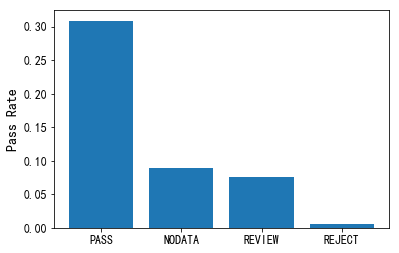

In [24]:
feature_analyse(df, 'result')

count            33919
unique               6
top       (11.8, 13.0]
freq             28222
Name: pay_num_band, dtype: object
-------------------------------------------
                all    pass  reject  pass_rate
(0.988, 2.2]   3844  1638.0    2206   0.426119
(3.4, 4.6]       57    11.0      46   0.192982
(2.2, 3.4]     1093   135.0     958   0.123513
(5.8, 7.0]      688    64.0     624   0.093023
(11.8, 13.0]  28222  1409.0   26813   0.049926
(9.4, 10.6]      15     0.0      15   0.000000


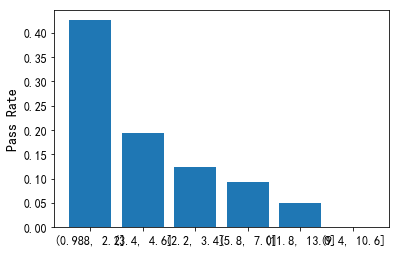

In [25]:
feature_analyse(df, 'pay_num')

count     33919
unique       20
top       JD_H5
freq      11630
Name: channel, dtype: object
-------------------------------------------
                            all  pass   reject  pass_rate
JDPAY-IOS                     7     7      0.0   1.000000
JDPAY-ANDROID                16    16      0.0   1.000000
ZERO_DOLLAR_RENT-ANDROID      7     7      0.0   1.000000
WXPAY-WEB                    44    44      0.0   1.000000
ZERO_DOLLAR_RENT-IOS         14    14      0.0   1.000000
ALIPAY-NULL                 475   475      0.0   1.000000
ALIPAY-WAP                  724   720      4.0   0.994475
ALIPAY-APP                  138   137      1.0   0.992754
ALIPAY-ANDROID              192   189      3.0   0.984375
JDPAY-WEB                   501   493      8.0   0.984032
ALIPAY-IOS                  421   409     12.0   0.971496
WXPAY-WXPUB                  37    33      4.0   0.891892
WXPAY-APP                   223   195     28.0   0.874439
WX_H5                       153     4    149.0   0.

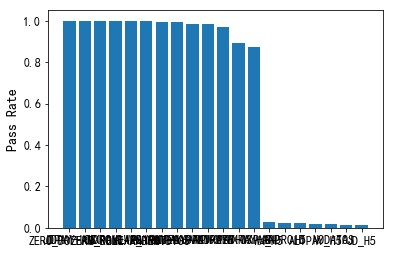

In [26]:
feature_analyse(df, 'channel')

In [27]:
# 芝麻分分类
bins = pd.IntervalIndex.from_tuples([(0, 600), (600, 700), (700, 800), (800, 1000)])
df['zmf_score_band'] = pd.cut(df['zmf_score'], bins, labels=False)
df[['zmf_score_band', 'check_result']].groupby(['zmf_score_band'], as_index=False).mean().sort_values(by='check_result', ascending=False)

,zmf_score_band,check_result
3,"(800, 1000]",0.724638
2,"(700, 800]",0.339403
1,"(600, 700]",0.077327
0,"(0, 600]",0.072815


In [28]:
# 小白分分类
bins = pd.IntervalIndex.from_tuples([(0, 80), (80, 90), (90, 100), (100, 200)])
df['xbf_score_band'] = pd.cut(df['xbf_score'], bins, labels=False)
df[['xbf_score_band', 'check_result']].groupby(['xbf_score_band'], as_index=False).mean().sort_values(by='check_result',
                                                                                                      ascending=False)

,xbf_score_band,check_result
3,"(100, 200]",0.154882
1,"(80, 90]",0.099517
2,"(90, 100]",0.076283
0,"(0, 80]",0.010101


In [29]:
# 年龄分类
bins = pd.IntervalIndex.from_tuples([(0, 18), (18, 24), (24, 30), (30, 40), (40, 100)])
df['age_band'] = pd.cut(df['age'], bins, labels=False)
df[['age_band', 'check_result']].groupby(['age_band'], as_index=False).mean().sort_values(by='check_result',ascending=False)

,age_band,check_result
3,"(30, 40]",0.112765
2,"(24, 30]",0.111429
1,"(18, 24]",0.087084
4,"(40, 100]",0.073232
0,"(0, 18]",0.020524


In [30]:
# 下单时间分类
df['create_hour_band'] = pd.cut(df['create_hour'], 5, labels=False)
df[['create_hour_band', 'check_result']].groupby(['create_hour_band'], as_index=False).mean().sort_values(by='check_result',ascending=False)

,create_hour_band,check_result
3,3,0.105359
2,2,0.105146
4,4,0.094302
1,1,0.093684
0,0,0.068053


In [31]:
features = ['check_result', 'result', 'pay_num', 'channel', 'goods_type', 'type', 'order_type',
            'source', 'phone_book', 'old_level', 'sex', 'create_hour', 'age_band', 'zmf_score_band',
            'xbf_score_band', ]
df = df[features]
# 类别特征全部转换成数字
for feature in features:
    df[feature] = LabelEncoder().fit_transform(df[feature])

print("保存的数据量: {}".format(df.shape))
df.to_csv(os.path.join(PROJECT_ROOT_DIR, "datasets", "mibaodata_ml.csv"), index=False)

保存的数据量: (33919, 15)


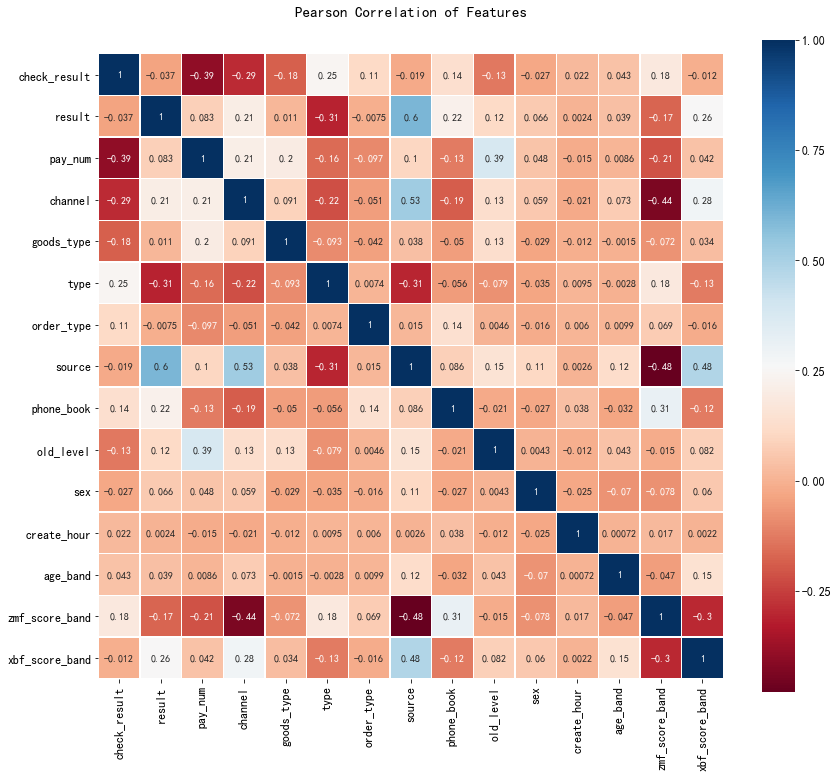

In [32]:
# 查看各特征关联度
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df.astype(float).corr(), linewidths=0.1, vmax=1.0,
            square=True, cmap=plt.cm.RdBu, linecolor='white', annot=True)

## 机器学习训练、预测

In [33]:
import time
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import KFold
from xgboost import XGBClassifier

# to make output display better
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 1000)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
# read large csv file
PROJECT_ROOT_DIR = os.getcwd()
DATA_ID = "mibaodata_ml.csv"
DATASETS_PATH = os.path.join(PROJECT_ROOT_DIR, "datasets", DATA_ID)
# Get Data
df = pd.read_csv(DATASETS_PATH, encoding='utf-8', engine='python')
print("ML初始数据量: {}".format(df.shape))

x = df.drop(['check_result'], axis=1)
y = df['check_result']
## Splitting the dataset into the Training set and Test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# 保存所有模型得分
def add_score(score_df, name, runtime, y_pred, y_test):
    score_df[name] = [accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred),
                      f1_score(y_test, y_pred), runtime, confusion_matrix(y_test, y_pred)]

    return score_df

score_df = pd.DataFrame(index=['accuracy', 'precision', 'recall', 'f1', 'runtime', 'confusion_matrix'])

rnd_clf = RandomForestClassifier(random_state=0)
starttime = time.clock()
rnd_clf.fit(x_train, y_train)
y_pred = rnd_clf.predict(x_test)
add_score(score_df, rnd_clf.__class__.__name__, time.clock() - starttime, y_pred, y_test)

print(score_df)

ML初始数据量: (33919, 15)
                   RandomForestClassifier
accuracy                          0.98069
precision                        0.941781
recall                           0.850077
f1                               0.893582
runtime                          0.279587
confusion_matrix  [[6103, 34], [97, 550]]


###### 评估结果
* accuracy： 97.6%  --- 预测正确的个数占样本总数的比率
* precision： 89.8% --- 预测通过正确的个数占预测通过的比率
* recall：84.1% --- 预测通过正确的个数占实际通过的比率
* F1 score 0.868 --- precision 和 recall 的加权平均

RandomForestClassifier roc socore: 0.944943372350522


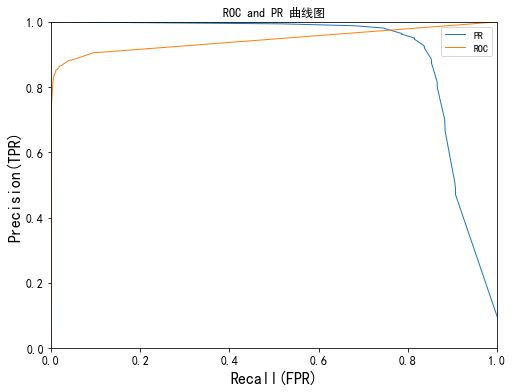

In [34]:
# 使用PR曲线： 当正例较少或者关注假正例多假反例。 其他情况用ROC曲线
plt.figure(figsize=(8, 6))
plt.xlabel("Recall(FPR)", fontsize=16)
plt.ylabel("Precision(TPR)", fontsize=16)
plt.axis([0, 1, 0, 1])

clf = rnd_clf
y_train_pred = cross_val_predict(clf, x_train, y_train, cv=3)    
y_probas = cross_val_predict(clf, x_train, y_train, cv=3, method="predict_proba", n_jobs=-1)
y_scores = y_probas[:, 1]  # score = proba of positive class 
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
plt.plot(recalls, precisions, linewidth=1, label="PR")
fpr, tpr, thresholds = roc_curve(y_train, y_scores)
print("{} roc socore: {}".format(clf.__class__.__name__, roc_auc_score(y_train, y_scores)))
plt.plot(fpr, tpr, linewidth=1, label="ROC")

plt.title("ROC and PR 曲线图")
plt.legend()
plt.show()

## 总结
1. 机器学习能洞察复杂问题和大量数据，发现内在规律，帮助我们做好数据挖掘方面的工作。
2. 很有很多的改进空间：
        a.现有数据特征挖掘，譬如同盾和白骑士中的内容详情，IP地址、收货地址、身份证地址、居住地址中的关联，优惠券，额外服务意外险，每日租金，手机号前三位等。与客户和订单信息相关的数据都可以拿来做特征，提高机器学习预测能力。
        b. 创造未被保存到数据库中的特征：年化利率,是否有2个手机号。
        c. 调整机器学习参数，使之更适合做预测分类。
        d. 使用更好的模型。XGBoosting、LightGBM和人工神经网络在训练和预测能力上做到更好。
3. 工作计划：
        a. 增加特征。需数据库里保存所有订单审核前的所有信息。目前折扣金额和额外服务等数据只有再审核通过后才保存，需更改下。
        b. 参考同类型行业，借鉴他人经验，增加相关特征
        c. 增加模型预测能力，ROC分数达到0.96以上， 预测准确度达到98.5%
        d. 增加客户信用额度字段。如何确定客户额度方案未知。
        e. 部署模型，模型监控。
    